In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys  
sys.path.append("../l2hmc")
sys.path.append("../l2hmc/utils")

import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from utils.distributions import random_tilted_gaussian, Gaussian, GMM, RoughWell

import seaborn as sns
sns.set_palette("muted")

In [2]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, \
    get_data, binarize, normal_kl, acl_spectrum, ESS
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Sequential, Zip, Parallel, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.notebook_utils import get_hmc_samples, plot_gaussian_contours

In [3]:
# Color definition for plots
c_l2hmc, c_hmc1, c_hmc2, c_hmc3 = 'blue', 'orange', 'green', 'red'
c_true, c_contour = 'purple', '0.75'

---
# Network architecture

In [4]:
def network(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, 10, scope='embed_1', factor=1.0 / 3),
                Linear(x_dim, 10, scope='embed_2', factor=factor * 1.0 / 3),
                Linear(2, 10, scope='embed_3', factor=1.0 / 3),
                lambda _: 0.,
            ]),
            sum,
            tf.nn.relu,
            Linear(10, 10, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(10, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(10, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(10, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])  
        ])
        
    return net


---
# 1D High Curvature Gaussian

## Defining the distribution

In [5]:
x_dim = 1
mu = np.zeros(x_dim)
#cov = np.array([0.01])
cov = np.array([[1, 0], [0,1]])
dist = Gaussian(mu, cov)
# mu, cov = random_tilted_gaussian(x_dim)
# Ω = Gaussian(mu, cov)

1.0 int64


We can directly sample from this distribution and plot it for sanity-check. Here, we sample 400 points from $\Omega$.

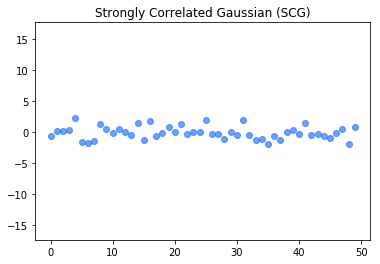

In [6]:
S = np.random.randn(50)
main, secondary = '#0C63FF', '#0EE6C0'
plt.title('Strongly Correlated Gaussian (SCG)')
plt.plot(S, 'o', alpha=0.6, color=main)
# sns.kdeplot(S[:, 0], S[:, 1], cmap="winter", shade=False, shade_lowest=False)
plt.axis('equal')
plt.show()

In [7]:
#x_lim, y_lim = np.max(S[:, 0]), np.max(S[:, 1])
#x_lims, y_lims = [-x_lim, x_lim], [-y_lim, y_lim]
#plot_gaussian_contours([mu], [cov], x_lims=x_lims, y_lims=y_lims, spacing=3)
# plt.axis('equal')
#plt.show()

---
## Training


We set up the loss on both $p(\xi)$ (here `x`) and $q(\xi)$ (here `z`). We then train with Adam with a learning rate of $10^{-3}$.

In [8]:
# Leap frog integrator for Hamiltonian dynamics
def energy_fct(x):
    y = 25*x**2
    return tf.squeeze(y)

dynamics = Dynamics(x_dim, energy_fct, T=10, eps=0.1, net_factory=network)

# Losses on p(xi) and q(xi), respectively
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x))
Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

# Squared jumped distance
v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 0.1

# Update loss
loss = 0.
loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale

In [9]:
# Training parameters
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

Training loop described in Algorithm 1 in the paper.

In [10]:
n_steps = 5000
n_samples = 200

samples = np.random.randn(n_samples, x_dim)
#samples = dist.get_samples(n=n_samples)

sess = tf.Session()#config=tf.ConfigProto(device_count = {'GPU': 0}))
sess.run(tf.global_variables_initializer())

for t in range(n_steps):
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], {x: samples})

    if t % 100 == 0:
        print('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss_, np.mean(px_), lr_))

InvalidArgumentError: Input to reshape is a tensor with 1 values, but the requested shape has 0
	 [[Node: gradients/Mean_2_grad/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients/Neg_grad/Neg, gradients/Mean_2_grad/DynamicStitch/_167)]]

Caused by op u'gradients/Mean_2_grad/Reshape', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/nic/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/nic/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/nic/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/nic/.local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/nic/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/nic/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nic/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/nic/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/nic/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/nic/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/nic/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/nic/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/nic/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/nic/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/nic/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/nic/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/nic/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/nic/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-0d43929f3bed>", line 5, in <module>
    train_op = optimizer.minimize(loss, global_step=global_step)
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 343, in minimize
    grad_loss=grad_loss)
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/training/optimizer.py", line 414, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 581, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 353, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py", line 581, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py", line 98, in _MeanGrad
    sum_grad = _SumGrad(op, grad)[0]
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py", line 62, in _SumGrad
    grad = array_ops.reshape(grad, output_shape_kept_dims)
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3938, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op u'Mean_2', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
[elided 18 identical lines from previous traceback]
  File "/home/nic/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-57922cf3e094>", line 22, in <module>
    loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 1411, in reduce_mean
    name=name)
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2568, in _mean
    keep_dims=keep_dims, name=name)
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/nic/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 1 values, but the requested shape has 0
	 [[Node: gradients/Mean_2_grad/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients/Neg_grad/Neg, gradients/Mean_2_grad/DynamicStitch/_167)]]


---
## Evaluating
After training, we generate 200 chains for 2000 steps for evaluation purposes.

In [ ]:
#samples = dist.get_samples(n=n_samples)
samples = np.random.randn(n_samples, x_dim)
final_samples = []

for t in range(2000):
    final_samples.append(np.copy(samples))

    feed_dict = {
        x: samples,
    }

    samples = sess.run(output[0], feed_dict)

We compute the HMC chains with **auto-correlation spectrums** as well.

In [ ]:
L2HMC_samples = np.array(final_samples)
HMC_samples_1 = get_hmc_samples(x_dim, 0.1, energy_fct, sess, steps=2000, samples=samples)
#HMC_samples_2 = get_hmc_samples(x_dim, 0.1, energy_fct, sess, steps=2000, samples=samples)
#HMC_samples_3 = get_hmc_samples(x_dim, 0.125, energy_fct, sess, steps=2000, samples=samples)

In [ ]:
scale = np.sqrt(np.trace(cov))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
#HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
#HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

---
## Auto-correlation plot

In [ ]:
xaxis = 10 * np.arange(20)
plt.plot(xaxis, L2HMC[:20], label='L2HMC', color=c_l2hmc)
plt.plot(xaxis, HMC1[:20], label='HMC $\epsilon=0.1$', color=c_hmc2)
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient computations')
plt.title('Concentrated 1D Gaussian')
plt.legend()
plt.show()

We now compute the **Effective Sample Size** (ESS).

In [ ]:
print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC1), ESS(L2HMC) / ESS(HMC1)))

Finally, we visualize a single chain of L2HMC for 50 time steps to assess exploration.

In [ ]:
#plt.plot(S[:, 0], S[:, 1], 'o', alpha=0.6, color=main)
#plt.plot(L2HMC_samples[:50, 1, 0], L2HMC_samples[:50, 1, 1], color=secondary, marker='o', alpha=0.8)
plt.plot(HMC_samples_1[:200, 1, 0], color="blue", marker='o', alpha=0.8)
plt.plot(L2HMC_samples[:200, 1, 0], color="red", marker='o', alpha=0.8)
plt.legend(['Original', 'L2HMC'])
plt.show()